## cv2.findHomography

parameters:
1. **srcPoints**	Coordinates of the points in the original plane, a matrix of the type CV_32FC2 or vector<Point2f>
2. **dstPoints**	Coordinates of the points in the target plane, a matrix of the type CV_32FC2 or a vector<Point2f>
3. **methods**
4. **ransacReprojThreshold**\
https://docs.opencv.org/master/d9/d0c/group__calib3d.html#ga4abc2ece9fab9398f2e560d53c8c9780

## cv2.drawMatches

The **keypoint** is characterized by the 2D position, scale (proportional to the diameter of the neighborhood that needs to be taken into account), orientation and some other parameters. The keypoint neighborhood is then analyzed by another algorithm that builds a descriptor (usually represented as a feature vector). The keypoints representing the same object in different images can then be matched using KDTree or another method.\
parameters:
1. **img1**	First source image.
2. **keypoints1**	Keypoints from the first source image.
3. **img2**	Second source image.
4. **keypoints2**	Keypoints from the second source image.
5. **matches1to2**	Matches from the first image to the second one, which means that keypoints1[i] has a corresponding point in keypoints2[matches[i]] .
6. **outImg**	Output image. Its content depends on the flags value defining what is drawn in the output image. See possible flags bit values below.
7. **matchesMask**	Mask determining which matches are drawn. If the mask is empty, all matches are drawn.

### cv2.DMatch
Class for matching keypoint descriptors.

query descriptor index, train descriptor index, train image index, and distance between descriptors.

(1, 2)   44
keypoint is the list which has 61 values with  <KeyPoint 0000010F5504FD50>
Maches is the list which has  44  values with  <DMatch 0000010F5722E570>
Mask matches have same amount of values which is  44  with 0 or 1 values each indicates which mask should be drawn


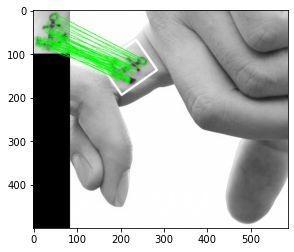

In [2]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

MIN_NUM_GOOD_MATCHES = 10

img0 = cv2.imread('img/query.png',
                  cv2.IMREAD_GRAYSCALE)
img1 = cv2.imread('img/anchor-man.png',
                  cv2.IMREAD_GRAYSCALE)

# Perform SIFT feature detection and description.
sift = cv2.xfeatures2d.SIFT_create()
kp0, des0 = sift.detectAndCompute(img0, None)
kp1, des1 = sift.detectAndCompute(img1, None)

# Define FLANN-based matching parameters.
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)

# Perform FLANN-based matching.
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des0, des1, k=2)

# Find all the good matches as per Lowe's ratio test.
good_matches = []
for m, n in matches:
    if m.distance < 0.7 * n.distance:
        good_matches.append(m)

if len(good_matches) >= MIN_NUM_GOOD_MATCHES:
    src_pts = np.float32(
        [kp0[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    dst_pts = np.float32(
        [kp1[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)
    print(src_pts[0].shape, " ", len(src_pts))
    M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
    mask_matches = mask.ravel().tolist()

    h, w = img0.shape
    src_corners = np.float32(
        [[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
    dst_corners = cv2.perspectiveTransform(src_corners, M)
    dst_corners = dst_corners.astype(np.int32)

    # Draw the bounds of the matched region based on the homography.
    num_corners = len(dst_corners)
    for i in range(num_corners):
        x0, y0 = dst_corners[i][0]
        if i == num_corners - 1:
            next_i = 0
        else:
            next_i = i + 1
        x1, y1 = dst_corners[next_i][0]
        cv2.line(img1, (x0, y0), (x1, y1), 255, 3, cv2.LINE_AA)

    # Draw the matches that passed the ratio test.
    # keypoints are the location of important features
    print("keypoint is the list which has", len(kp0), "values with ", kp0[0])
    print("Maches is the list which has ", len(good_matches), " values with ", good_matches[0])
    print("Mask matches have same amount of values which is ", len(mask_matches), " with 0 or 1 values each indicates which mask should be drawn")
    img_matches = cv2.drawMatches(
        img0, kp0, img1, kp1, good_matches, None,
        matchColor=(0, 255, 0), singlePointColor=None,
        matchesMask=mask_matches, flags=2)

    # Show the homography and good matches.
    plt.imshow(img_matches)
    plt.show()
else:
    print("Not enough matches good were found - %d/%d" % \
          (len(good_matches), MIN_MATCH_COUNT))
